# 9.ChIP-seq
## 9.5.ChIP データの品質管理（QC）
### 今回使用するサンプル
1. 転写因子（TF）: CTCF, SMC3, ZNF143, PolII (RNA polymerase 2)
1. ヒストン修飾: H3K4me3, H3K36me3, H3k27ac, H3k27me3
1. Input データ

In [5]:
# ChIP-seq のデータを読み込む
data_path = "../data/chip-seq"
chip_files = list.files(data_path, full.names=TRUE)

In [7]:
# 染色体情報を読み込むライブラリを呼び出す
library(GenomeInfoDb)

In [8]:
# ヒトゲノムの染色体長を取得
# getChromInfoFromUCSC： UCSC のゲノム情報を使用する
hg_chrs = getChromInfoFromUCSC('hg38')

In [9]:
# ヒトゲノムの21番染色体を取得
# grepl: chr21$ に一致するかどうか boolean で返す
# subset: data.frame(データフレーム) から grepl で true となる対象データを抽出する 
hg_chrs = subset(hg_chrs, grepl('chr21$',chrom))

In [10]:
# ヒトゲノムの21番染色体を表示してみる
hg_chrs

,chrom,size,assembled,circular
,<chr>,<int>,<lgl>,<lgl>
21,chr21,46709983,TRUE,FALSE


In [11]:
# ダウンロードしたヒトゲノムの染色体長のデータ: data.frame(データフレーム)というデータ構造
# これを data.frame(データフレーム) から 名前付きベクター(配列)にデータ構造を変換する
# setnames: chrom を名前とした size の名前付きベクターを作成する
# with: データ構造を変換したり、データの絞り込みを行ったりできる(ここでは名前付きベクターにデータ構造を変換している)
seqlengths = with(hg_chrs, setNames(size, chrom))

In [12]:
seqlengths

chr21 
46709983

In [13]:
# ゲノム範囲(レンジ)を扱うためのパッケージを読み込み
library(GenomicRanges)

In [14]:
# tileGenome: GRanges オブジェクト(chr21 を 1000bp ごとに切り出す)を返す 
# window size -> 1000bp
tilling_window = tileGenome(seqlengths, tilewidth=1000)
# GRanges オブジェクトをリストに変換
tilling_window = unlist(tilling_window)

In [15]:
tilling_window

GRanges object with 46710 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]    chr21            1-1000      *
      [2]    chr21         1001-2000      *
      [3]    chr21         2001-3000      *
      [4]    chr21         3001-4000      *
      [5]    chr21         4001-5000      *
      ...      ...               ...    ...
  [46706]    chr21 46704985-46705984      *
  [46707]    chr21 46705985-46706984      *
  [46708]    chr21 46706985-46707984      *
  [46709]    chr21 46707985-46708984      *
  [46710]    chr21 46708985-46709983      *
  -------
  seqinfo: 1 sequence from an unspecified genome

In [17]:
# GenomicAlignments ライブラリの読み込み
library(GenomicAlignments)

# データフォルダから BAM 拡張子を持つファイルのみを取得
bam_files = list.files(
    path       = data_path, 
    full.names = TRUE, 
    pattern    = 'bam$'
)

In [18]:
# window ごとにリードカウント
# summarizeOverlaps: 指定した領域のリードをカウントする
so = summarizeOverlaps(tilling_window, bam_files)

In [25]:
# Window × サンプルのリードカウントのマトリクスを作成
counts = assays(so)[[1]]
counts

GM12878_hg38_CTCF_r1.chr21.bam,GM12878_hg38_CTCF_r2.chr21.bam,GM12878_hg38_H3K27me3.chr21.bam,GM12878_hg38_H3K36me3.chr21.bam,GM12878_hg38_H3K4me1.chr21.bam,GM12878_hg38_H3K4me3.chr21.bam,GM12878_hg38_Input_r1.chr21.bam,GM12878_hg38_Input_r2.chr21.bam,GM12878_hg38_Input_r3.chr21.bam,GM12878_hg38_Input_r4.chr21.bam,GM12878_hg38_Input_r5.chr21.bam,GM12878_hg38_SMC3_r1.chr21.bam,GM12878_hg38_SMC3_r2.chr21.bam,GM12878_hg38_ZNF143_r1.chr21.bam,GM12878_hg38_ZNF143_r2.chr21.bam
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# 上記のカウントマトリクスから、CPM(100万リードあたりのカウント数) を算出 
# colSums: マトリクスの列ごとに合計値を算出(この場合、サンプルごとのリード合計値を計算)
# t: マトリクスの列と行を転置
cpm = t(t(counts)*(1000000/colSums(counts)))

In [27]:
# すべてのサンプルで 0カウントの window を削除
# MEMO: 0カウントの window を残しておくと、後に行うサンプル感の相関チェックで、擬似的な相関が取れてしまうため(すべて 0 なので相関があると計算されてしまう)
cpm = cpm[rowSums(cpm) > 0,]
cpm

GM12878_hg38_CTCF_r1.chr21.bam,GM12878_hg38_CTCF_r2.chr21.bam,GM12878_hg38_H3K27me3.chr21.bam,GM12878_hg38_H3K36me3.chr21.bam,GM12878_hg38_H3K4me1.chr21.bam,GM12878_hg38_H3K4me3.chr21.bam,GM12878_hg38_Input_r1.chr21.bam,GM12878_hg38_Input_r2.chr21.bam,GM12878_hg38_Input_r3.chr21.bam,GM12878_hg38_Input_r4.chr21.bam,GM12878_hg38_Input_r5.chr21.bam,GM12878_hg38_SMC3_r1.chr21.bam,GM12878_hg38_SMC3_r2.chr21.bam,GM12878_hg38_ZNF143_r1.chr21.bam,GM12878_hg38_ZNF143_r2.chr21.bam
0.0000,0,16.864828,8.679877,12.937926,5.478263,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,13.019816,18.482751,4.382611,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,0.000000,4.339939,12.937926,6.573916,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,13.019816,24.027576,10.956527,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,8.679877,85.020654,16.434790,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,4.339939,234.730937,59.165244,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,0.000000,17.359755,303.117116,44.921759,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,30.379571,256.910239,59.165244,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,21.699694,266.151614,70.121771,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,25.297243,17.359755,125.682707,175.304427,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000


In [28]:
# ファイル名が長ったらしいので、余計な文字列を削ります
# .chr21.bam suffix を削除
colnames(cpm) = sub('.chr21.bam','',   colnames(cpm))

# GM12878_hg38 prefix を削除
colnames(cpm) = sub('GM12878_hg38_','',colnames(cpm))

In [29]:
cpm

CTCF_r1,CTCF_r2,H3K27me3,H3K36me3,H3K4me1,H3K4me3,Input_r1,Input_r2,Input_r3,Input_r4,Input_r5,SMC3_r1,SMC3_r2,ZNF143_r1,ZNF143_r2
0.0000,0,16.864828,8.679877,12.937926,5.478263,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,13.019816,18.482751,4.382611,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,0.000000,4.339939,12.937926,6.573916,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,13.019816,24.027576,10.956527,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,8.679877,85.020654,16.434790,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,4.339939,234.730937,59.165244,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,0.000000,17.359755,303.117116,44.921759,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,16.864828,30.379571,256.910239,59.165244,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,8.432414,21.699694,266.151614,70.121771,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
0.0000,0,25.297243,17.359755,125.682707,175.304427,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000


In [30]:
# サンプル間のピアソンの相関係数を算出
correlation_matrix = cor(cpm, method='pearson')

In [31]:
# ComplexHeatmapライブラリの読み込み
library(ComplexHeatmap)

# circlize ライブラリを読み込み
library(circlize)

In [34]:
# ヒートマップに使用するカラーパレットを定義
heatmap_col = circlize::colorRamp2(
    breaks = c(-1,0,1),
    colors = c('blue','white','red')
)

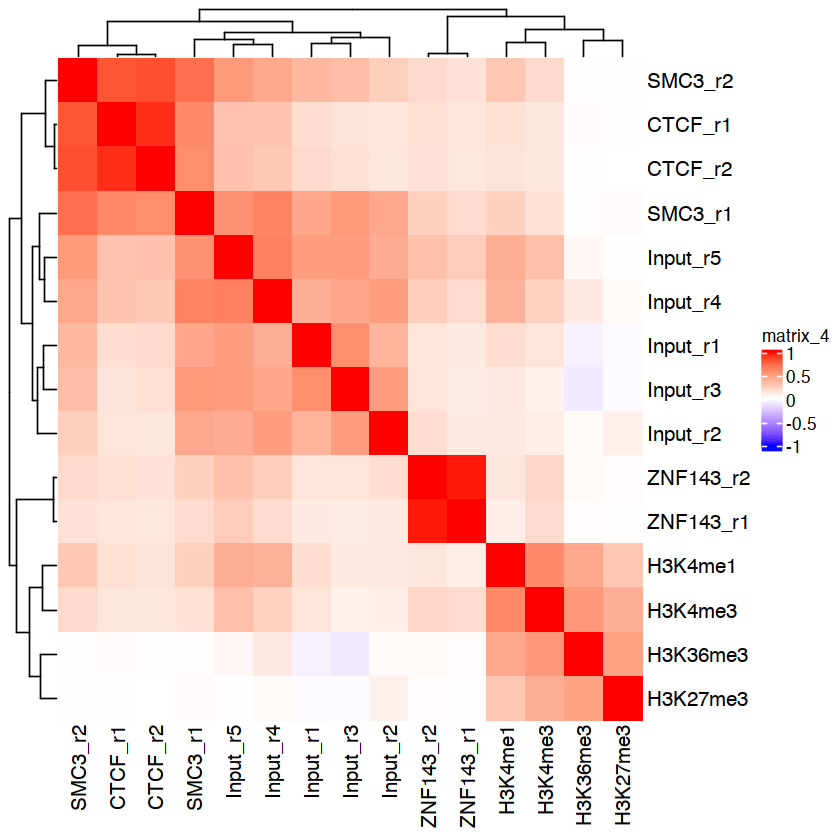

In [35]:
# ヒートマップを作成
Heatmap(
    matrix = correlation_matrix, 
    col    = heatmap_col
)

コヒーシンのサブユニットである SMC3 と コヒーシンの複合体と結合する CTCF の ChIP-seq のデータに強い相関が見られるはずである。  
CTCF_r1, CTCF_r2, SMC3_r2 の間には強い相関が見られるが、SMC3_r1 は Input データと強い相関が見られる。  
このことから、SMC3_r1 のデータはノイズの多い、Enrichment が低いサンプルであると予想される。

### 参考
- [ピアソンの相関の方法とスピアマンの相関の方法の比較](https://support.minitab.com/ja-jp/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/)
- [東京大学 定量生命科学研究所 ゲノム情報解析研究分野 白鬚研究室 研究テーマ](http://www.iam.u-tokyo.ac.jp/chromosomeinformatics/ResearchJ.html)
  - ![CTCF vs SMC3](http://www.iam.u-tokyo.ac.jp/chromosomeinformatics/img/fig5.jpg)

In [ ]:
## 